# Assignment 2

# Grade: /100

## Instructions

* Complete the Lab assignment

* Once the notebook is complete, restart your kernel and rerun your cells

* Submit this notebook to owl by the deadline

* You may use any python library functions you wish to complete the Lab assignment.



This notebook contains the questions for Assignment 2. Please note, a random seed has been set to ensure the reproducability of the results -- *DO NOT* change this random seed. **If you call additional functions that are based on random number generators, you will need to define their seed to 42 as well**. Make sure to complete this assignment individually and appropriately reference all external code and documentation used. 

In [13]:
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
import pandas as pd 
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score, accuracy_score, precision_score

np.random.seed(42)

## Dataset 

This assignment's objective is to develop a data-driven predictive model for the power consumption of an industrial refrigeration system using the `Data_Rack01` dataset.  
The data frame contains the following data, where each row represents a datapoint:

- Dew_Point: the temperature to which air must be cooled to become saturated with water vapor 
- Indoor_Humidity: The indoor Humidity
- Indoor_Temperature: The indoor temprature (Fahrenheit)
- Outdoor_Humidity: The outdoor humidity
- Outdoor_Temperature: The outdoor temprature (Fahrenheit)
- Discharge_Pressure: The pressure generated on the output side of a gas compressor in a refrigeration system
- Discharge_Temperature: The compressor's discharge temperature 
- KW: Power consumed
- Power_Factor: The power factor of the refrigeration system
- Volts_Line_to_Line
- Volts_Line_to_Neutral

## Question 1 (40 pts)

### a) Preprocess the data acording to the following:

1. Load data into a variable called myData
2. In the `myPreProc` function perform the following:
  - Remove the empty column(s), 
  - Drop rows with any missing data ("NA").
  - Remove the 'DeviceName' column as well

The processed data should be returned through the function variable `procData`



In [14]:
#Part 1a
#load data
myData = pd.read_csv('Data_Rack01.csv')

def myPreProc(data):
    procData = data.drop(['Discharge_Pressure', 'DeviceName'], axis=1)
    procData = procData.dropna()
    return procData

myData = myPreProc(myData)


### b) Define two loss functions:
- one that measures the absolute difference between observations and predictions. Return mean and standard deviation of the result.
- one that finds the absolute difference that is less than or equal to a threshold. Return mean and standard deviation of the result.



In [15]:
#Part 1b
def abs_diff_loss(obs, pred):
    resids = abs(obs - pred)
    return resids.mean(), resids.std(ddof=1)
    
def threshold_loss(obs, pred, thresh):
    resids = abs(obs - pred) <= thresh
    resids = resids.astype(int)
    return resids.mean(), resids.std(ddof=1)


### c) Data splitting:
- Use power consumption as the target variable for your machine learning model. 
- Split your preprocessed dataset by setting aside some amount of data for testing, and retaining the rest for training. Reserve 30 percent of your data for testing. *Make sure to set the random_state to 42 if you are using an sklearn function to accomplish this. 


In [16]:
#Part 1c
X = myData.drop(['kW'], axis=1)
y = myData.loc[:, 'kW']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


### d) Build a linear regression model:
- Using Ordinary Least Squares, build a model to predict power consumed (KW) as a `linear function` of the other variables (features) in the dataset. In order to properly build the regression model, the features need to be `standardized` so that no feature can dominate others in determining the prediction values due to differences in feature scales. Build a `pipeline` that **standardizes the features** and **creates a linear regression model**.
- Report the coefficient of determination (`R2 score`) when evaluating both the training and testing performance of your model.

In [17]:
#Part 1d
pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('linear_regression', LinearRegression())
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

r2 = r2_score(y_test, y_pred)
print(f'R2 score: {r2}')


R2 score: 0.4240761933328049


## Question 2 - Regularization (25 pts) 

- Use L2 regularization by adding a penalty of $\lambda \sum_{i}{\beta_i^2}$ (where $\beta_i$ are your regression coefficients) to the regression model. Vary the regularization parameter $\lambda$ between 0.2 and 250, evenly spaced in **log-space**, and generate 50 values. 
- Build the `pipeline` that **standardizes the features** and **create a regularized regression model**.
- Determine the 10-fold crossvalidated performance for different values of the L2-regularization parameters. Use the cross-validated R-Squared (R2) of the data under the model as evaluation criterion.  
- Make a plot of the cross-validated R-Squared (R2) against $log(\lambda)$. 
- Report the best lambda that you found

Best lambda: 0.19999999999999998


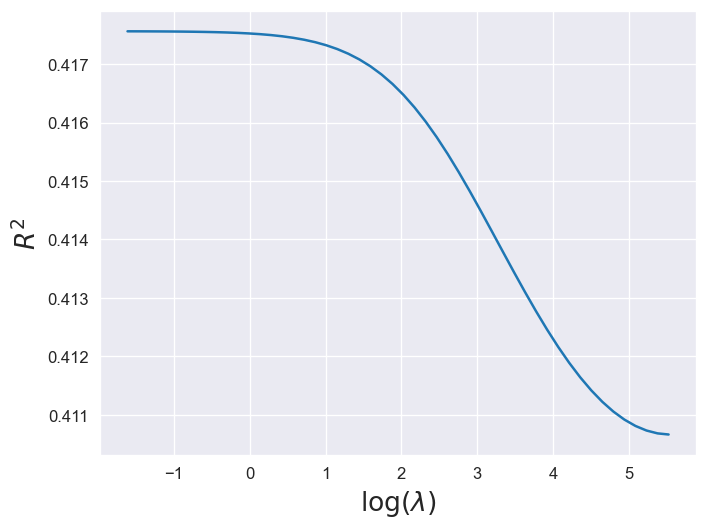

In [18]:
regularization_params = np.exp(np.linspace(np.log(0.2), np.log(250), 50))
cv_score_mean = np.zeros(regularization_params.size)

for i, L in enumerate(regularization_params):
    ridge_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('regression', Ridge(alpha=L, fit_intercept=True)) 
    ])
    
    cv_r2_score = cross_val_score(ridge_pipe, X_train, y_train, cv=10, scoring='r2')
    cv_score_mean[i]= cv_r2_score.mean()
    
fig, ax = plt.subplots(dpi = 120)
ax.plot(np.log(regularization_params), cv_score_mean)
ax.set_xlabel(r'$\log(\lambda)$', fontsize = 16)
ax.set_ylabel(r'$R^{2}$', fontsize = 16)

best_lamda = np.argmax(cv_score_mean)
print(f'Best lambda: {regularization_params[best_lamda]}')
    

## Question 3 - Classification (35 pts)

### a) Binary target:
- Convert your target variable in the dataset into a binary variable using >= mean thresholding (use the same data split as in Q1 part c). 


In [19]:
#Part 3a
mean_threshold = y_train.mean()

binary_y_train = y_train >= mean_threshold
binary_y_train = binary_y_train.astype(int)

binary_y_test = y_test >= mean_threshold
binary_y_test = binary_y_test.astype(int)


### b) Build logistic regression model:
- Define a Logistic Regression model and report the resulting *training* precision and *testing* accuracy of your model. Make sure the set the maximum number of iterations for your model to 10000 (use pipeline for normalization and model building same as Questions 1 and 2).


In [20]:
#Part 3b
lg_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=10000))
])

lg_pipe.fit(X_train, binary_y_train)
train_pred_1 = lg_pipe.predict(X_train)
test_pred_1 = lg_pipe.predict(X_test)

train_precision_1 = precision_score(binary_y_train, train_pred_1)
test_accuracy_1 = accuracy_score(binary_y_test, test_pred_1)

print(f"Training Precision: {train_precision_1:.4f}")
print(f"Testing Accuracy: {test_accuracy_1:.4f}")


Training Precision: 0.8050
Testing Accuracy: 0.8021


### c) Build a Support Vector Machine (SVM) model:
- Define a linear SVM model with default options and maximum number of iterations 10000. Report the resulting *training* precision and *testing* accuracy of your model (use pipeline for normalization and model building same as Questions 1 and 2).



In [21]:
#Part 3c
svm_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('classifier', LinearSVC(max_iter=10000))
])

svm_pipe.fit(X_train, binary_y_train)
train_pred_2 = svm_pipe.predict(X_train)
test_pred_2 = svm_pipe.predict(X_test)

train_precision_2 = precision_score(binary_y_train, train_pred_2)
test_accuracy_2 = accuracy_score(binary_y_test, test_pred_2)

print(f"Training Precision: {train_precision_2:.4f}")
print(f"Testing Accuracy: {test_accuracy_2:.4f}")

Training Precision: 0.8050
Testing Accuracy: 0.8021


### d) Comparison:
- Compare the performance of your models in `b` and `c` in terms of generalization performance and execution time, what do you conclude? 

*Part 3d*

`Written Answer:` The training precision and testing accuracy were the same for both models. The only difference I noticed was when using the standard scaler, when the models get standardized the training precision and testing accuracy improve significantly. For the execution time the SVM was slightly slower.